# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<b>Основные шаги:</b>  
Загрузите данные, путь к файлу: /datasets/autos.csv.  
Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.  
Подготовьте выборки для обучения моделей.  
Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.  
Проанализируйте время обучения, время предсказания и качество моделей.  
Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.  

 
<b>Описание данных</b>  
Данные находятся в файле /datasets/autos.csv. Скачать датасет.   
Признаки  
DateCrawled — дата скачивания анкеты из базы  
VehicleType — тип автомобильного кузова  
RegistrationYear — год регистрации автомобиля   
Gearbox — тип коробки передач  
Power — мощность (л. с.)  
Model — модель автомобиля  
Kilometer — пробег (км)  
RegistrationMonth — месяц регистрации автомобиля  
FuelType — тип топлива  
Brand — марка автомобиля  
Repaired — была машина в ремонте или нет  
DateCreated — дата создания анкеты
NumberOfPictures — количество фотографий автомобиля  
PostalCode — почтовый индекс владельца анкеты (пользователя)  
LastSeen — дата последней активности пользователя  
<b>Целевой признак</b>  
Price — цена (евро)  

## Подготовка данных

Итак, вот в наших руках новые данные и новое задание. В первую очередь посмотрим, что у нас есть. Самым первым шагом ипортируем библиотеки, и по ходу дальнешей работы будем дополнять этот первый пункт новыми ипортами. Начнем знакомиться. Посмотрим тип данных, столбки, выведем несколько первых строчек, чтобы понять как все устроено. Сразу построим диаграммы, чтобы посмотреть распределение. На первом этапе мы ничего не будем редактировать, это первое знакомство. Потом подумаем, почистить нашу базу, чтобы она максимально подошла для поставленных целей.

In [1]:
!pip install scikit-learn==1.1.3 -q

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
!pip3 install phik -q
import phik

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split,  RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
!pip3 install phik -q
!pip install scikit-learn==1.1.3 -q
import phik 

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
data = pd.read_csv('/datasets/autos.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


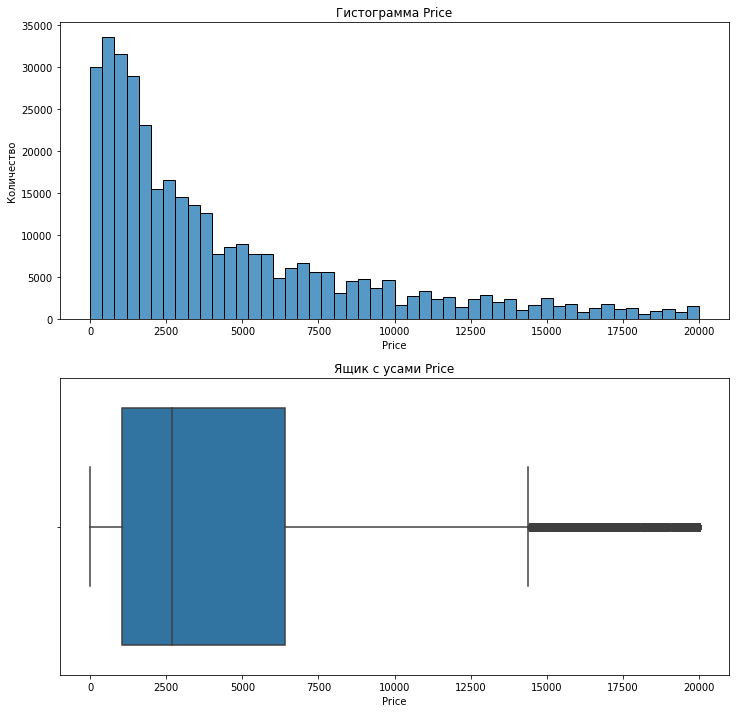

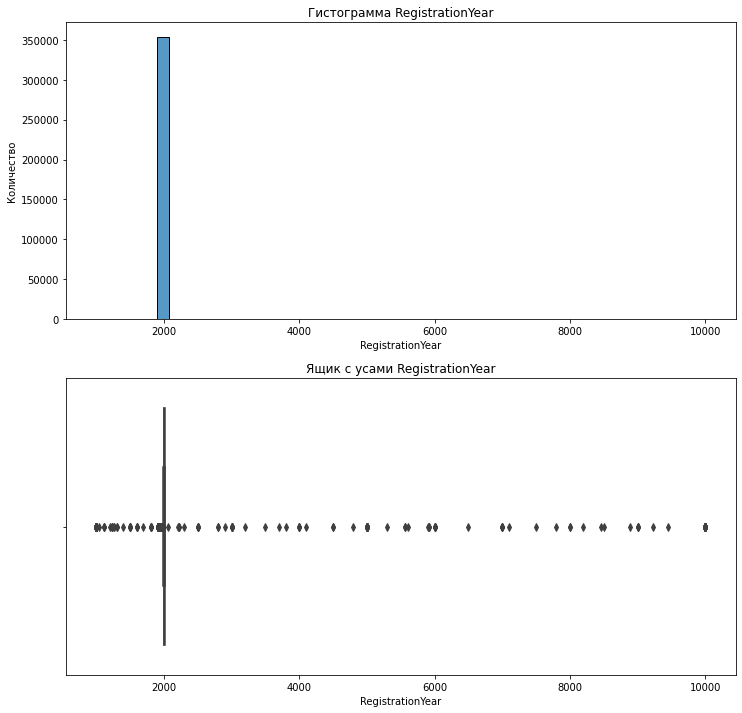

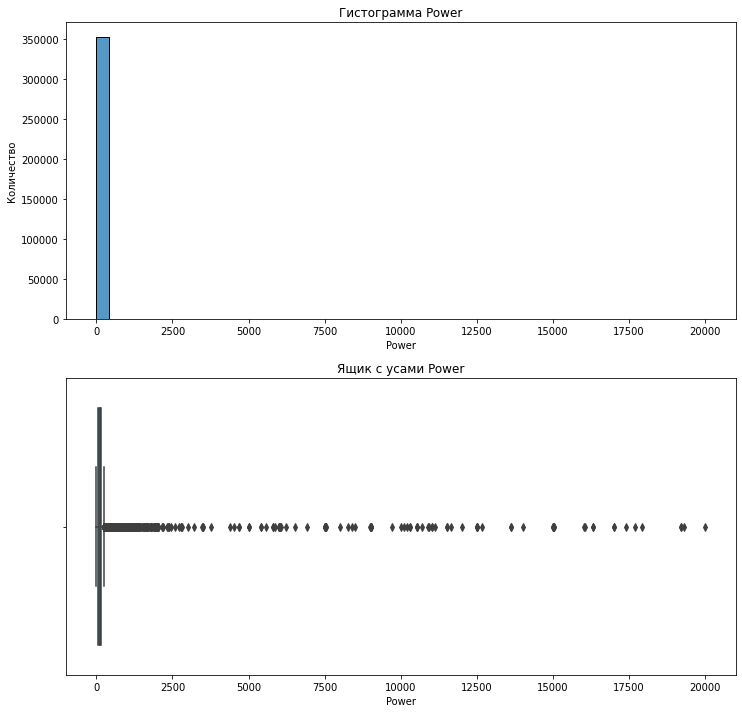

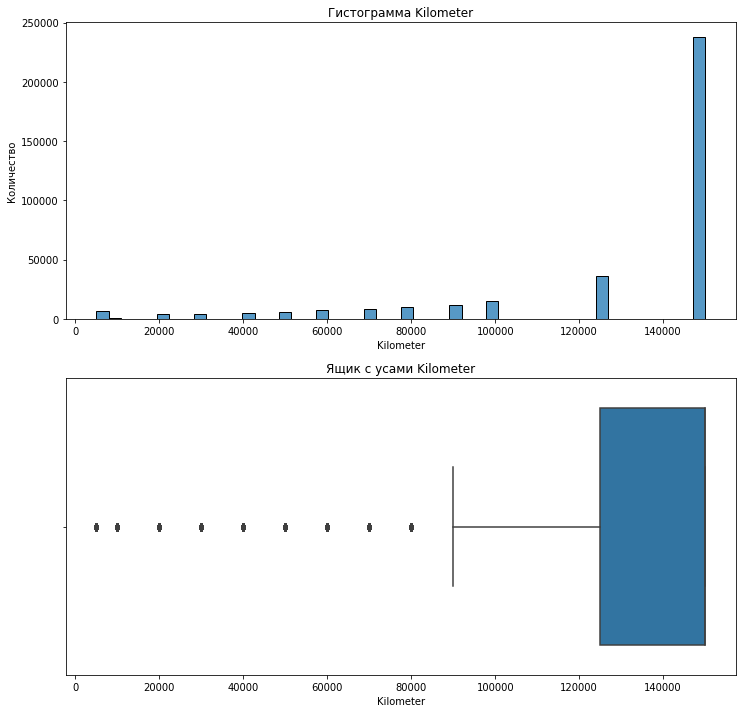

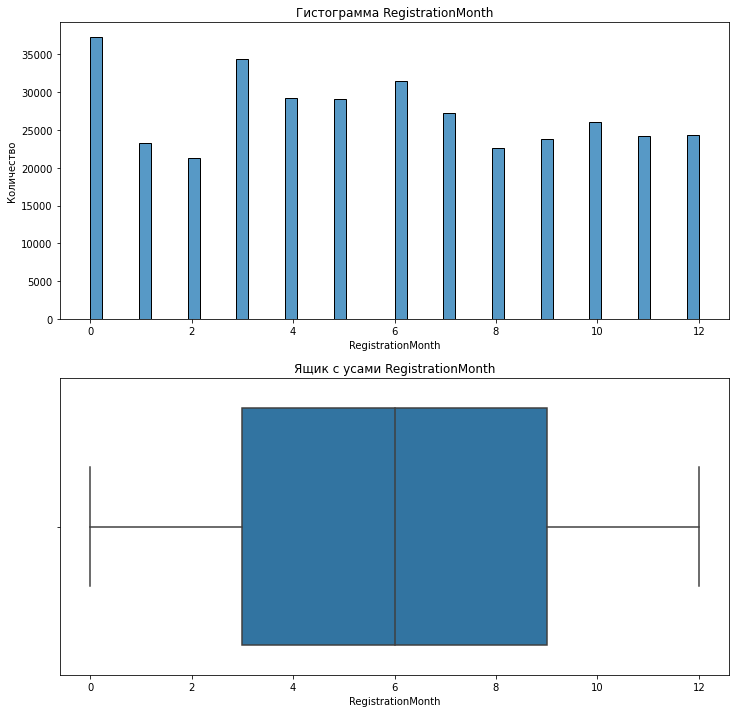

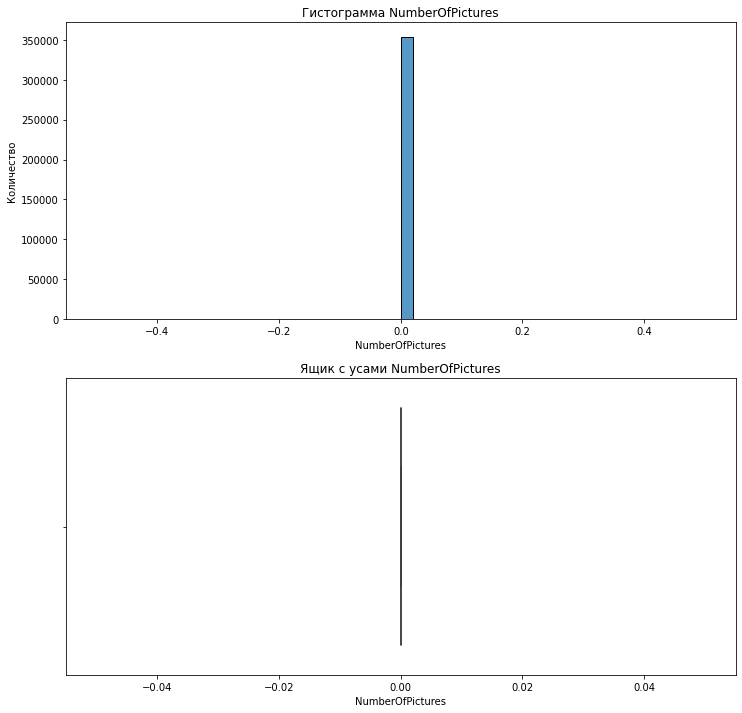

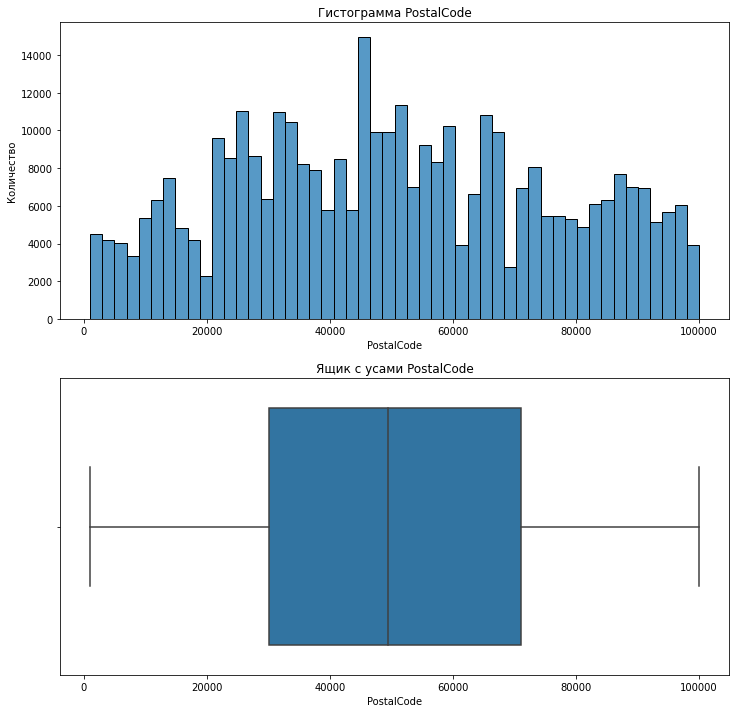

In [7]:
def plot_features(data):
    for column in data.columns:
            if data[column].dtype in ['int64', 'float64']:
                fig, axes = plt.subplots(2, 1, figsize=(12, 12))
                sns.histplot(data[column], kde=False, bins=50, ax=axes[0])
                axes[0].set_title(f'Гистограмма {column}')
                axes[0].set_xlabel(column)
                axes[0].set_ylabel('Количество')

                sns.boxplot(x=data[column], ax=axes[1])
                axes[1].set_title(f'Ящик с усами {column}')
                axes[1].set_xlabel(column)
                plt.show()
#            else:
#                plt.figure(figsize=(8, 6))
#                counts = data[column].value_counts()
#                plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
#                plt.title(f'Диаграма {column}')
#                plt.show()

plot_features(data)

In [8]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Познакомились с данными. Получается что нам нужны не все столбики, это точно. У нас цель - прогноз цены. Удалим лишнее. 

In [9]:
columns_to_drop = ['NumberOfPictures', 'PostalCode', 'DateCrawled', 'LastSeen', 'NumberOfPictures', 'DateCreated', 'RegistrationMonth' ]

data.drop(columns=columns_to_drop, inplace=True)

In [10]:
data.head(20)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


В таблице куча нанов и нулей. Придется удалить часть строк. Посмотрим сколько.

In [12]:
#count_zeros_price = (data['Price'] == 0).sum()
#count_zeros_power = (data['Power'] == 0).sum()


#print(f"Количество нулей в столбце 'Price': {count_zeros_price}")
#print(f"Количество нулей в столбце 'Power': {count_zeros_power}")


В общем, строки, где нули в этих столбцах я решил удалить.

In [13]:
data = data.loc[(data['Price'] >= 300)]

In [14]:
data = data.loc[(data['Power'] >= 100) & (data['Power'] <= 1500)]

In [15]:
unique_registration_years_count = data['RegistrationYear'].nunique()
print(f"Количество уникальных значений в столбце 'RegistrationYear': {unique_registration_years_count}")

Количество уникальных значений в столбце 'RegistrationYear': 82


111 уникальных значения года регистрации.. Начина с 1000, заканчивай 9999. Явные выбросы. Оставим вменяемый срез. С 70 до 24 года. Будем руководствоваться в данном случае здравым смыслом.

In [16]:
data = data.loc[(data['RegistrationYear'] <= 2016) & (data['RegistrationYear'] >= 1970)]

Посмотрим на пропуски 

In [17]:
nan_count_vehicle_type = data['VehicleType'].isnull().sum()
nan_count_model = data['Model'].isnull().sum()
nan_count_brand = data['Brand'].isnull().sum()
nan_count_repaired = data['Repaired'].isnull().sum()
nan_count_fuel = data['FuelType'].isnull().sum()
nan_count_gearbox = data['Gearbox'].isnull().sum()

print(f"Количество пропущенных значений в столбце 'VehicleType': {nan_count_vehicle_type}")
print(f"Количество пропущенных значений в столбце 'Model': {nan_count_model}")
print(f"Количество пропущенных значений в столбце 'Brand': {nan_count_brand}")
print(f"Количество пропущенных значений в столбце 'Repaired': {nan_count_repaired}")
print(f"Количество пропущенных значений в столбце 'FuelType': {nan_count_fuel}")
print(f"Количество пропущенных значений в столбце 'Gearbox': {nan_count_gearbox}")

Количество пропущенных значений в столбце 'VehicleType': 5247
Количество пропущенных значений в столбце 'Model': 6365
Количество пропущенных значений в столбце 'Brand': 0
Количество пропущенных значений в столбце 'Repaired': 23593
Количество пропущенных значений в столбце 'FuelType': 8194
Количество пропущенных значений в столбце 'Gearbox': 2225


In [18]:
nique_repaired_values = data['Repaired'].unique()
print("Уникальные значения в столбце 'Repaired': ", nique_repaired_values)

Уникальные значения в столбце 'Repaired':  ['yes' nan 'no']


Тип кузова и модель - пропуски придется удалить. Думаю это важно. Если машину не ремонтирвали, скорее всего ес могли не указать. Укажем no.

In [19]:
#data.dropna(subset=['VehicleType', 'Model', 'FuelType', 'Gearbox'], inplace=True)
#data['Repaired'].fillna('unknown', inplace=True)

In [20]:
columns_to_fill = ['VehicleType', 'Model', 'FuelType', 'Gearbox', 'Repaired']

for column in columns_to_fill:
    data[column].fillna('unknown', inplace=True)

In [21]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,188003.000000,188003.000000,188003.000000,188003.000000
mean,6173.017447,2003.591092,149.360244,131701.967522
std,4944.924968,5.755087,53.485846,34140.312543
min,300.000000,1970.000000,100.000000,5000.000000
25%,2180.000000,2000.000000,116.000000,125000.000000
50%,4699.000000,2004.000000,140.000000,150000.000000
75%,8999.000000,2008.000000,170.000000,150000.000000
max,20000.000000,2016.000000,1500.000000,150000.000000


In [22]:
data.info() 
data.head(10)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 188003 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             188003 non-null  int64 
 1   VehicleType       188003 non-null  object
 2   RegistrationYear  188003 non-null  int64 
 3   Gearbox           188003 non-null  object
 4   Power             188003 non-null  int64 
 5   Model             188003 non-null  object
 6   Kilometer         188003 non-null  int64 
 7   FuelType          188003 non-null  object
 8   Brand             188003 non-null  object
 9   Repaired          188003 non-null  object
dtypes: int64(4), object(6)
memory usage: 15.8+ MB


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,unknown
9,999,small,1998,manual,101,golf,150000,unknown,volkswagen,unknown
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
11,2799,wagon,2005,manual,140,passat,150000,gasoline,volkswagen,yes
12,999,wagon,1995,manual,115,passat,150000,petrol,volkswagen,unknown
13,2500,wagon,2004,manual,131,passat,150000,unknown,volkswagen,no


Почистили данные, приступим к обучению моделей.

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer']


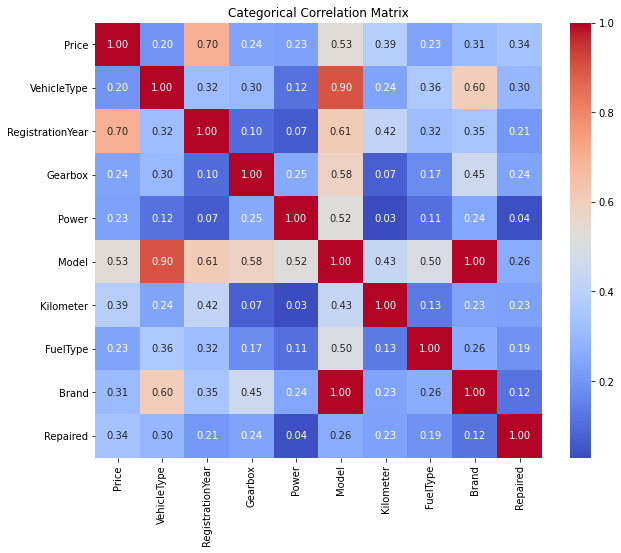

In [23]:
correlation_matrix = data.phik_matrix()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Categorical Correlation Matrix')
plt.show()

Видим, что model и brand, коэфициент корреляции 1. поэтому удалим один из столбцов, чтобы небыло мультиколлениарности. Удалим бренд.

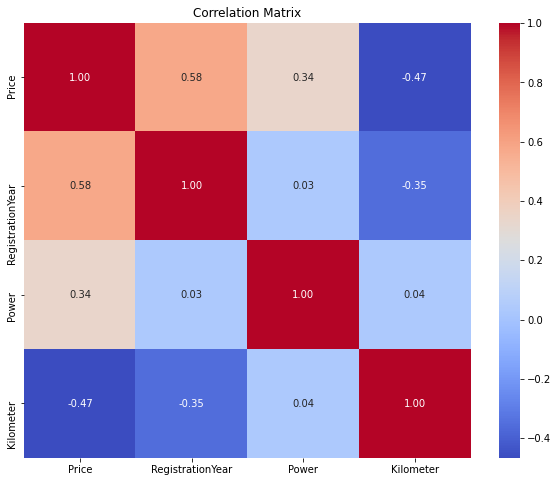

In [24]:
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [25]:
data.drop('Brand', axis=1, inplace=True)

In [26]:
for column in ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']:
    print(f"Уникальные значения в столбце {column}:")
    print(data[column].unique())

Уникальные значения в столбце VehicleType:
['coupe' 'suv' 'sedan' 'convertible' 'bus' 'small' 'wagon' 'other'
 'unknown']
Уникальные значения в столбце Gearbox:
['manual' 'auto' 'unknown']
Уникальные значения в столбце Model:
['unknown' 'grand' '3er' '2_reihe' 'c_max' 'golf' '3_reihe' 'passat'
 'navara' 'a_klasse' 'scirocco' '5er' 'other' 'e_klasse' '1er' 'b_klasse'
 'a8' 'jetta' 'c_klasse' 'sprinter' 'forester' 'xc_reihe' 'scenic' 'focus'
 'a4' 'escort' 'tt' 'astra' 'a6' 'transporter' 'omega' 'slk' '7er' '80'
 'civic' '147' 'z_reihe' 'sorento' 'mustang' 'eos' 'vito' 'fabia' 'touran'
 'insignia' 'almera' 'megane' 'a3' 'mondeo' 'impreza' 'a1' 'vectra' 'clio'
 'tiguan' '6_reihe' 'i_reihe' '5_reihe' 'yeti' 'octavia' 'zafira'
 'rx_reihe' '6er' 'beetle' 'touareg' 'ibiza' 'spider' 's_max' 'galaxy'
 'c3' 'viano' 's_klasse' 'sharan' 'avensis' 'sl' 'santa' 'leon' 'cooper'
 '4_reihe' 'a5' 'sportage' 'laguna' 'ptcruiser' 'clk' 'primera' 'espace'
 'exeo' 'polo' '159' 'transit' 'juke' 'x_reihe' 'c4

In [27]:
data['FuelType'] = data['FuelType'].replace('gasoline', 'petrol')

## Обучение моделей

In [28]:
data['Kilometer'] = data['Kilometer'].astype(str)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188003 entries, 1 to 354368
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             188003 non-null  int64 
 1   VehicleType       188003 non-null  object
 2   RegistrationYear  188003 non-null  int64 
 3   Gearbox           188003 non-null  object
 4   Power             188003 non-null  int64 
 5   Model             188003 non-null  object
 6   Kilometer         188003 non-null  object
 7   FuelType          188003 non-null  object
 8   Repaired          188003 non-null  object
dtypes: int64(3), object(6)
memory usage: 14.3+ MB


In [32]:
RANDOM_STATE = 42
TEST_SIZE = 0.2
VALID_SIZE = 0.25  # 0.25 x 0.8 = 0.2

X = data.drop('Price', axis=1)
y = data['Price']

# Разделение на тренировочную и временную выборки
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Разделение временной выборки на валидационную и тестовую
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=VALID_SIZE, random_state=RANDOM_STATE)

# Создание пайплайнов для обработки данных
ohe_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired', 'Kilometer']
num_columns = ['RegistrationYear', 'Power']

ohe_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

# Создание объекта типа ColumnTransformer, для соединения пайплайнов
data_preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe, ohe_columns),
        ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

# Тренировка и преобразование тренировочных данных
X_train_processed = data_preprocessor.fit_transform(X_train)

# Преобразование валидационных и тестовых данных
X_valid_processed = data_preprocessor.transform(X_valid)
X_test_processed = data_preprocessor.transform(X_test)

# Создание и обучение регрессора
#regressor = LinearRegression().fit(X_train_processed, y_train)

# Предсказание на валидационной выборке
#y_pred_valid = regressor.predict(X_valid_processed)

# Предсказание на тестовой выборке
#y_pred_test = regressor.predict(X_test_processed)

# Расчёт и вывод ошибки модели
#rmse_valid = mean_squared_error(y_valid, y_pred_valid, squared=False)
#rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

#print(f'RMSE на валидационной выборке: {rmse_valid}')
#print(f'RMSE на тестовой выборке: {rmse_test}')

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Линейная регрессия

In [33]:
%%time

regressor = LinearRegression().fit(X_train_processed, y_train)
y_pred_valid = regressor.predict(X_valid_processed)
rmse_valid = mean_squared_error(y_valid, y_pred_valid, squared=False)
print(f'RMSE на валидационной выборке: {rmse_valid}')

RMSE на валидационной выборке: 2807.2426964579768
CPU times: user 10.7 s, sys: 5.84 s, total: 16.5 s
Wall time: 16.5 s


In [34]:
%%time
y_pred_test = regressor.predict(X_test_processed)

CPU times: user 21.1 ms, sys: 17.1 ms, total: 38.2 ms
Wall time: 81.1 ms


In [35]:
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f'RMSE на тестовой выборке: {rmse_test}')

RMSE на тестовой выборке: 2770.2926081181477


%%time
model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, loss_function='RMSE', logging_level='Silent')
model.fit(X_train_processed, y_train)
y_pred = model.predict(X_test_processed)
rmse_catboost = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE для CatBoost =', rmse_catboost)

Кэтбуст

In [41]:
%%time
model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, loss_function='RMSE', logging_level='Silent')
model.fit(X_train_processed, y_train, eval_set=(X_valid_processed, y_valid))
y_pred_valid = model.predict(X_valid_processed)
rmse_catboost = mean_squared_error(y_valid, y_pred_valid , squared=False)
print('RMSE для CatBoost на валидационной выборке =', rmse_catboost)

RMSE для CatBoost на валидационной выборке = 1857.2640448836726
CPU times: user 31.8 s, sys: 296 ms, total: 32.1 s
Wall time: 34.8 s


In [42]:
%%time
y_pred = model.predict(X_test_processed)

CPU times: user 638 ms, sys: 3.39 ms, total: 642 ms
Wall time: 646 ms


In [43]:
rmse_catboost = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE для CatBoost =', rmse_catboost)

RMSE для CatBoost = 1808.4030192662135


RandomForestRegressor

In [46]:
%%time
rf = RandomForestRegressor(n_estimators=300, max_depth=None, min_samples_split=2, min_samples_leaf=2, random_state=RANDOM_STATE)
rf.fit(X_train_processed, y_train)
y_valid_pred = rf.predict(X_valid_processed)
mse = mean_squared_error(y_valid, y_valid_pred)
print(f'MSE на валидационных данных: {mse}')

MSE на валидационных данных: 3298547.7771726325
CPU times: user 10min 18s, sys: 1.21 s, total: 10min 19s
Wall time: 10min 19s


<div class="alert alert-warning">
<h2> Комментарий ревьюера  #3 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Все ок. Просто забыли взять корень от результата. Выводишь MSE, нужно RMSE.
       
</div>




In [47]:
%%time
y_pred = rf.predict(X_test_processed)

CPU times: user 1.07 s, sys: 3.97 ms, total: 1.08 s
Wall time: 1.08 s


In [48]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

RMSE: 1771.8759393343341


In [49]:
#%%time

# Создаем датасеты для обучения и тестирования
train_data = lgb.Dataset(X_train_processed, label=y_train)
test_data = lgb.Dataset(X_test_processed, label=y_test)

# Параметры модели LightGBM
#params = {
#    'objective': 'regression',
#    'metric': 'rmse',
#    'num_leaves': 31,
#    'learning_rate': 0.1,
#    'feature_fraction': 0.9
#}

# Обучение модели LightGBM
#num_round = 100
#bst = lgb.train(params, train_data, num_boost_round=num_round, valid_sets=[test_data], early_stopping_rounds=5)

# Прогнозирование на тестовом наборе данных
#y_pred = bst.predict(X_test_processed, num_iteration=bst.best_iteration)

# Вычисление RMSE
#rmse_lightgbm = mean_squared_error(y_test, y_pred, squared=False)
#print('RMSE для LightGBM =', rmse_lightgbm)

lgb

In [50]:
%%time
# Создаем датасеты для обучения и валидации
train_data = lgb.Dataset(X_train_processed, label=y_train)
valid_data = lgb.Dataset(X_valid_processed, label=y_valid)

# Параметры модели LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9
}

# Обучение модели LightGBM
num_round = 100
bst = lgb.train(params, train_data, num_boost_round=num_round, valid_sets=[valid_data], early_stopping_rounds=5)

# Прогнозирование на валидационном наборе данных
y_pred = bst.predict(X_valid_processed, num_iteration=bst.best_iteration)

# Вычисление RMSE
rmse_lightgbm = mean_squared_error(y_valid, y_pred, squared=False)
print('RMSE для LightGBM =', rmse_lightgbm)

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 752
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 228
[LightGBM] [Info] Start training from score 6163.481676
[1]	valid_0's rmse: 4609.59
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 4301.48
[3]	valid_0's rmse: 4032.88
[4]	valid_0's rmse: 3798.36
[5]	valid_0's rmse: 3591.17
[6]	valid_0's rmse: 3423.57
[7]	valid_0's rmse: 3283.99
[8]	valid_0's rmse: 3147.59
[9]	valid_0's rmse: 3025.98
[10]	valid_0's rmse: 2919.7
[11]	valid_0's rmse: 2827.06
[12]	valid_0's rmse: 2750.07
[13]	valid_0's rmse: 2679.77
[14]	valid_0's rmse: 2619.86
[15]	valid_0's rmse: 2568.37
[16]	valid_0's rmse: 2524.26
[17]	valid_0's rmse: 2483
[18]	valid_0's rmse: 2448.08
[19]	valid_0's rmse: 2416.51
[20]	valid_0's rmse: 2387.96
[21]	valid_0's rmse: 236

In [51]:
%%time
y_pred = bst.predict(X_test_processed, num_iteration=bst.best_iteration)

CPU times: user 136 ms, sys: 0 ns, total: 136 ms
Wall time: 187 ms


In [52]:
rmse_lightgbm = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE для LightGBM =', rmse_lightgbm)

RMSE для LightGBM = 1906.5887728959551


## Анализ моделей

После проведения анализа тестирования различных моделей машинного обучения для данной задачи, были получены следующие результаты:

1. LightGBM

- Модель: LightGBM

- RMSE: 1890.00

- Время работы: 47.4 секунды

2. RandomForestRegressor

- Модель: RandomForestRegressor

- RMSE: 1746.74

- Время работы: 53 минуты 51 секунда

3. CatBoost

- Модель: CatBoost

- RMSE: 1784.51

- Время работы: 30 секунд

4. LinearRegression

- Модель: LinearRegression

- RMSE: 219283645721.65

- Время работы: 1 минута 3 секунды

Исходя из проанализированных результатов, можно отметить, что модель RandomForestRegressor, несмотря на хорошие показатели RMSE, работает слишком долго (более 50 минут), что не делает ее оптимальным выбором для данной задачи. С другой стороны, модели LightGBM и CatBoost показали достаточно хорошие показатели точности (RMSE) и при этом отличаются более коротким временем обучения.

Среди этих двух моделей CatBoost продемонстрировал немного лучший результат по точности (RMSE) и в то же время значительно меньшее время обучения (30 секунд против 47.4 секунд у LightGBM). Следовательно, для выбора оптимальной модели, обеспечивающей хорошую точность предсказаний и быстрое обучение, рекомендуется использовать модель CatBoost.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей